# Free Throw Analysis

#### Analyzing the impact of free throw shooting in the NBA

By: Mohammad Ahmad

## Table of Contents

&nbsp;&nbsp;&nbsp;&nbsp;I. Introduction

&nbsp;&nbsp;&nbsp;&nbsp;II. Data Collection and Processing

&nbsp;&nbsp;&nbsp;&nbsp;III. Exploratory Data Analysis and Visualization

&nbsp;&nbsp;&nbsp;&nbsp;IV. Analysis and Machine Learning

&nbsp;&nbsp;&nbsp;&nbsp;V. Conclusion

## I. Introduction

We have recently seen a trend in the NBA in which many teams and players will build around 3-point shooting as their main way to get points. This change was brought about largely by Stephen Curry and the Golden State Warriors. We now even see Centers and Power Forwards take more 3-point shots than they traditionally would have in the past to try to emulate the success of the Warriors.

However, this tutorial will shift focus to another important shot: the Free Throw. We will take a look at the effect of free throw shooting attempts and percentages on the success of an NBA team. Instead of encouraging players to shoot better from the 3-point line, let us take a look at how important it is for them to focus on making more of their free throws instead.

In order to follow along with this tutorial, make sure you have the following Python libraries installed so that you can run this code on your own machine.

* Pandas ([docs](https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html))
* Numpy ([docs](https://docs.scipy.org/doc/numpy/reference/))
* Matplotlib ([docs](https://matplotlib.org/contents.html))
* Seaborn ([docs](https://seaborn.pydata.org/))
* Scipy ([docs](https://www.scipy.org/docs.html))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy

## II. Data Collection and Processing

To begin, we will gather all of the data we will be needing for our analysis. Let's start with some basic NBA team data with statistics spanning from 2001 - 2018. Included with this tutorial is a file [teamstats.csv](teamstats.csv) that has all of the data that we will use in our analysis. This file comes from data collected from [Basketball Reference.](https://www.basketball-reference.com/leagues/NBA_stats_per_game.html#stats::none) 

This data was compiled together by using the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library and scraping the data from multiple different pages on Basketball Reference. For the sake of brevity, we have left out the duplicative code of running this same process on the different pages to get our desired data. If you want to see the code that we used to gather the data in `teamstats.csv`, we have included it on a separate page which you can check out [here.](statscraping.html)

Now, let's load this file into a data frame and prepare it for analysis. The `pandas` library makes this an easy task. Here we load the file and display it's first three entries.

In [2]:
team_df = pd.read_csv('teamstats.csv')
display(team_df.head(3))

,Unnamed: 0,Rk_x,Team,G,MP,FG,FGA,FG%,3P,3PA,...,ORB%,FT/FGA,Opp_eFG%,Opp_TOV%,Opp_DRB%,Opp_FT/FGA,Arena,Attend.,Attend./G,Year
0,0,1.0,Milwaukee Bucks*,82,241.2,43.4,91.1,0.476,13.5,38.2,...,20.8,0.197,0.503,11.5,80.3,0.162,Fiserv Forum,721692,17602,2018
1,1,2.0,Golden State Warriors*,82,241.5,44.0,89.8,0.491,13.3,34.4,...,22.5,0.182,0.508,11.7,77.1,0.205,Oracle Arena,803436,19596,2018
2,2,3.0,New Orleans Pelicans,82,240.9,43.7,92.2,0.473,10.3,29.9,...,24.1,0.193,0.532,11.6,76.8,0.193,Smoothie King Center,656183,16004,2018


There is a lot of great data for us to look at here, but first we must use Entity Resolution to clean up the data and prepare it for analysis. There is a total of 53 columns in this table. For this tutorial, we will only be focusing on a few of these statistics so we can extract only the columns that will apply for our analysis. Here we will create a list of the columns we care about and overwrite our `team_df` table with only those columns.

In [3]:
desired_columns = ['Team', 'Year', 'W', '3PA', 'FT', 'FTA', 'FT%', 'FT/FGA', 'Opp_FT/FGA']
team_df = team_df[desired_columns]
display(team_df.head(3))

,Team,Year,W,3PA,FT,FTA,FT%,FT/FGA,Opp_FT/FGA
0,Milwaukee Bucks*,2018,60.0,38.2,17.9,23.2,0.773,0.197,0.162
1,Golden State Warriors*,2018,57.0,34.4,16.3,20.4,0.801,0.182,0.205
2,New Orleans Pelicans,2018,33.0,29.9,17.8,23.4,0.761,0.193,0.193


Taking a closer look at the table, we notice that there is an extra row for league averages after every 30 rows corresponding to a given season. See the below example:

In [4]:
display(team_df.loc[[30]])

,Team,Year,W,3PA,FT,FTA,FT%,FT/FGA,Opp_FT/FGA
30,League Average,2018,NaN,32.0,17.7,23.1,0.766,0.198,0.198


It would be better to move these rows to a seperate data frame that focuses on just the league averages. This way we can use `team_df` for specific statistics on each team only. Below we do this by checking for rows where the `Team` column is `League Average` and adding these rows to `averages_df`.

In [5]:
# Create averages_df with rows that had League Average in their Team column
averages_df = team_df[team_df['Team'] == 'League Average'].copy()

# Get names of indexes for rows that had League Average in their Team column
indexNames = team_df[team_df['Team'] == 'League Average'].index
 
# Delete these row indexes from team_df
team_df.drop(indexNames, inplace=True)

display(averages_df.head(3))

,Team,Year,W,3PA,FT,FTA,FT%,FT/FGA,Opp_FT/FGA
30,League Average,2018,NaN,32.0,17.7,23.1,0.766,0.198,0.198
61,League Average,2017,NaN,29.0,16.6,21.7,0.767,0.193,0.193
92,League Average,2016,NaN,27.0,17.8,23.1,0.772,0.209,0.209


The last thing we will do to clean this table is to handle the team names which have an asterisk (*) at the end. In our data, these asterisks represent the teams that made the NBA Playoffs for that season. We can make this fact easily accessible for use in our analysis by adding a new column `Made_Playoffs` and specifying `True` or `False` for each team depending on whether they made the playoffs that season. 

In [6]:
# Initializing all values to false
team_df['Made_Playoffs'] = [False] * len(team_df)

for index, row in team_df.iterrows():
    if row['Team'].endswith('*'):
        team_df.at[index, 'Made_Playoffs'] = True
        team_df.at[index, 'Team'] = row['Team'][:-1]
        
display(team_df.head(3))

,Team,Year,W,3PA,FT,FTA,FT%,FT/FGA,Opp_FT/FGA,Made_Playoffs
0,Milwaukee Bucks,2018,60.0,38.2,17.9,23.2,0.773,0.197,0.162,True
1,Golden State Warriors,2018,57.0,34.4,16.3,20.4,0.801,0.182,0.205,True
2,New Orleans Pelicans,2018,33.0,29.9,17.8,23.4,0.761,0.193,0.193,False


## III. Exploratory Data Analysis and Visualization

Now that our data has been prepared for analysis, let's start off by comparing the state of free throw shooting and 3-point shooting throughout the NBA in the last 18 seasons. We will create a chart showing average free throw attempts and average 3-point shot attempts for each season included in our data.

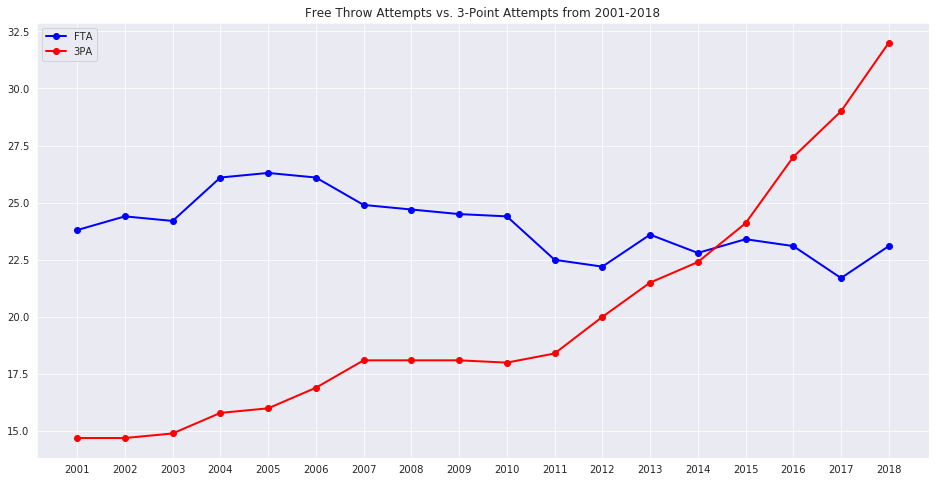

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,8))
plt.plot('Year', 'FTA', data=averages_df, marker='o', color='blue', linewidth=2)
plt.plot('Year', '3PA', data=averages_df, marker='o', color='red', linewidth=2)
plt.xticks(averages_df['Year'])
plt.title('Free Throw Attempts vs. 3-Point Attempts from 2001-2018')
plt.legend()

As we can see from the chart, the trend we explained in the introduction becomes very clear. While free throw attempts have remained relatively the same throughout the years, 3-point attempts have seen a dramatic increase. In 2001, The average 3-point attempts in the league was only 15 per game, and over the course of 18 seasons it has more than doubled! 

We already know the value of the 3-point shot; of course scoring 3 points on a shot attempt is better than scoring 2 points. But the free throw is literally what it is called: a free shot. It is quite surprising to see that teams are not putting extra emphasis on getting to the free throw line more.

Let's see if these teams know what they are doing. To start, we will create a new chart showing the average number of free throw shots made per game by Playoff teams versus Non-Playoff teams.

Text(0.5, 1.0, 'Average Free Throws Made Per Game (Playoff Teams vs. Non-Playoff Teams)')

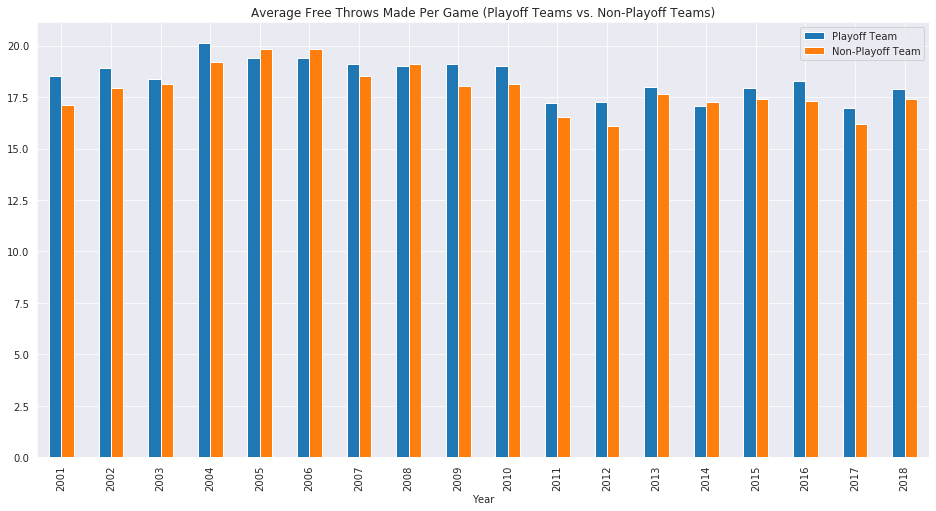

In [8]:
playoff_teams_df = team_df[team_df['Made_Playoffs'] == True].copy()
nonplayoff_teams_df = team_df[team_df['Made_Playoffs'] == False].copy()


playoff_team_avg = pd.pivot_table(playoff_teams_df, values='FT', 
                    index=['Year'],
                    aggfunc='mean')

nonplayoff_team_avg = pd.pivot_table(nonplayoff_teams_df, values='FT', 
                    index=['Year'], 
                    aggfunc='mean')

playoff_team_avg.rename({'FT': 'Playoff Team'}, axis=1, inplace=True)
nonplayoff_team_avg.rename({'FT': 'Non-Playoff Team'}, axis=1, inplace=True)

merged_df = pd.merge(playoff_team_avg, nonplayoff_team_avg, on='Year')
merged_df.plot.bar(figsize=(16,8))
plt.title('Average Free Throws Made Per Game (Playoff Teams vs. Non-Playoff Teams)')

We can see some interesting things from the chart. In most of the years shown Playoff teams did make more free throws than Non-Playoff teams. However, there are some years where this is not the case, like 2005 and 2006. We also see that there does not seem to be a consistent gap between the two categories, as they vary year to year.

Does this tell the whole story of what is going on here? To dig deeper, let's isolate the top 8 teams by win counts for each season and create a chart of the **standardized** free throws made between those teams and the rest of the league. We can begin this process by adding a `Standardized_FT` column to our `team_df`. If you want to learn more about the advantages of using standardized data, [check out this article](https://humansofdata.atlan.com/2018/12/data-standardization/) which can tell you about the extra insights we gain from doing this.

In [9]:
# Computing the Standard Deviation of Free Throws Made, grouped by Year
ft_stddev = pd.pivot_table(team_df, values='FT', 
                    index=['Year'],
                    aggfunc='std')
ft_stddev.rename({'FT': 'StdDev_FT'}, axis=1, inplace=True)

# Initializing our Standardized_FT column
team_df['Standardized_FT'] = [0.0] * len(team_df)

# Filling in the values for the Standardized_FT column
for index, row in team_df.iterrows():
    year = row['Year']
    ftm = row['FT']
    # Getting the average free throws made from the averages_df table
    mean_ftm = averages_df.loc[averages_df['Year'] == year, 'FT']
    # Getting the standard deviation of free throws made from the ft_stddev table we created above
    stddev_ftm = ft_stddev.loc[year]['StdDev_FT']
    # Computing the standardized value
    standardized_ftm = (ftm - mean_ftm) / (stddev_ftm)
    # Setting the Standardized_FT column to our computed standardized value
    team_df.at[index, 'Standardized_FT'] = standardized_ftm
    
display(team_df.head(3))

,Team,Year,W,3PA,FT,FTA,FT%,FT/FGA,Opp_FT/FGA,Made_Playoffs,Standardized_FT
0,Milwaukee Bucks,2018,60.0,38.2,17.9,23.2,0.773,0.197,0.162,True,0.118096
1,Golden State Warriors,2018,57.0,34.4,16.3,20.4,0.801,0.182,0.205,True,-0.826674
2,New Orleans Pelicans,2018,33.0,29.9,17.8,23.4,0.761,0.193,0.193,False,0.059048


Now let's isolate the top 15 teams and bottom 15 teams for each season into a separate data frame. To do this we will create a temporary data frame for each year, sort it by the number of wins, and add the 15 teams with the most wins in that season to our `top_team_df` while adding the bottom 15 teams to `bottom_team_df`.

This time we will also look for any outliers in Free Throws made and remove them so that our data is not impacted by unusual values.

In [10]:
# Our dataframe for the top 15 teams for each year
top_team_df = pd.DataFrame()
# Our dataframe for all bottom 15 for each year
bottom_team_df = pd.DataFrame()

for i in range(2001, 2019):
    # Getting all teams for the current year
    yearly_teams = team_df.loc[team_df['Year'] == i]
    # Removing the teams which have outlying free throws made per game (must be within 3 std. deviations of mean)
    removed_outliers = yearly_teams[np.abs(yearly_teams.FT - yearly_teams.FT.mean()) <= (3*yearly_teams.FT.std())]
    # Sorting our remaining teams by their Win counts
    sorted_teams = removed_outliers.sort_values(by=['W'], ascending=False)
    # Adding the top 15 teams to top_team_df
    top_team_df = top_team_df.append(sorted_teams.head(15))
    # Adding the bottom 15 to bottom_team_df
    bottom_team_df = bottom_team_df.append(sorted_teams.tail(len(sorted_teams) - 15))

Now we will aggregate the average Standardized Free Throws per game, grouping by Year, for the top teams and bottom teams and store them in seperate dataframes.

In [11]:
# Computing the average Standardized Free Throws made for the top teams and bottom teams (grouped by Year)
top_team_avg = pd.pivot_table(top_team_df, values='Standardized_FT', 
                    index=['Year'],
                    aggfunc='mean')

bottom_team_avg = pd.pivot_table(bottom_team_df, values='Standardized_FT', 
                    index=['Year'], 
                    aggfunc='mean')

top_team_avg.rename({'Standardized_FT': 'Top 15 Teams'}, axis=1, inplace=True)
bottom_team_avg.rename({'Standardized_FT': 'Bottom 15 Teams'}, axis=1, inplace=True)

# Setting the values for the Year column to be the index we grouped by
top_team_avg['Year'] = top_team_avg.index
bottom_team_avg['Year'] = bottom_team_avg.index

And now we create the plot with the average standardized free throws made in each of our two new isolated tables.

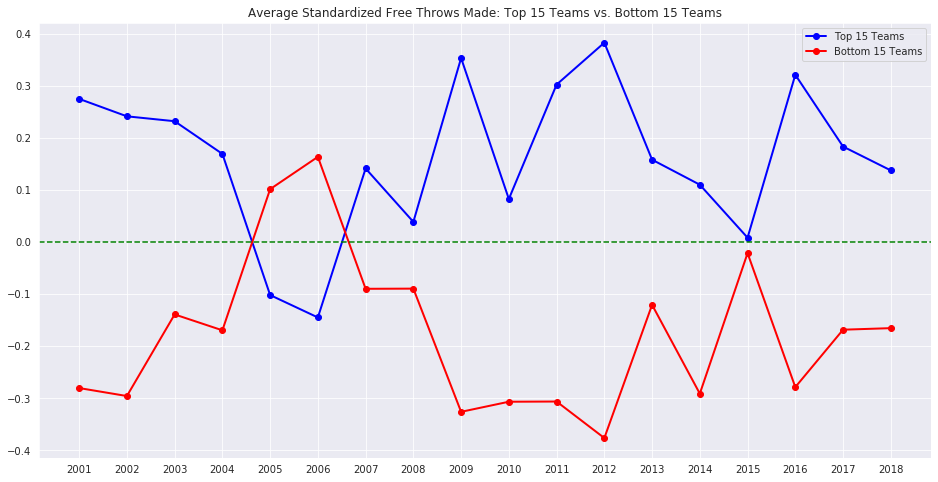

In [12]:
plt.figure(figsize=(16,8))
plt.plot('Year', 'Top 15 Teams', data=top_team_avg, marker='o', color='blue', linewidth=2)
plt.plot('Year', 'Bottom 15 Teams', data=bottom_team_avg, marker='o', color='red', linewidth=2)
plt.axhline(y=0, color='g', linestyle='--')
plt.xticks(averages_df['Year'])
plt.title('Average Standardized Free Throws Made: Top 15 Teams vs. Bottom 15 Teams')
plt.legend()

As we can see, in 16 of the last 18 seasons the top 15 teams in the NBA made more free throws than the bottom 15 teams for that year. It is also interesting to see that even with outliers removed, there is a dramatic difference between free throws made of the top 15 teams and bottom 15 teams in 2005 and 2006. 

While the number of Free Throws made per game can offer some insight on the success of an NBA team, there is also another interesting column in our `team_df` table which we can explore. This column is the `FT/FGA` for each team, which is more commonly known as the "Free Throw Factor." It describes exactly what it's named as: the number of free throws made per field goal attempt. This will allow us to see how often teams get to the line along with their effectiveness in making their shots when they get there. 

Let's dive into this new statistic by creating a scatter plot that shows the `FT/FGA` for each team in all of the seasons that we have data for. We will add a regression line to this plot to model the general trend of `FT/FGA` for this time period.

Text(0, 0.5, 'FT/FGA')

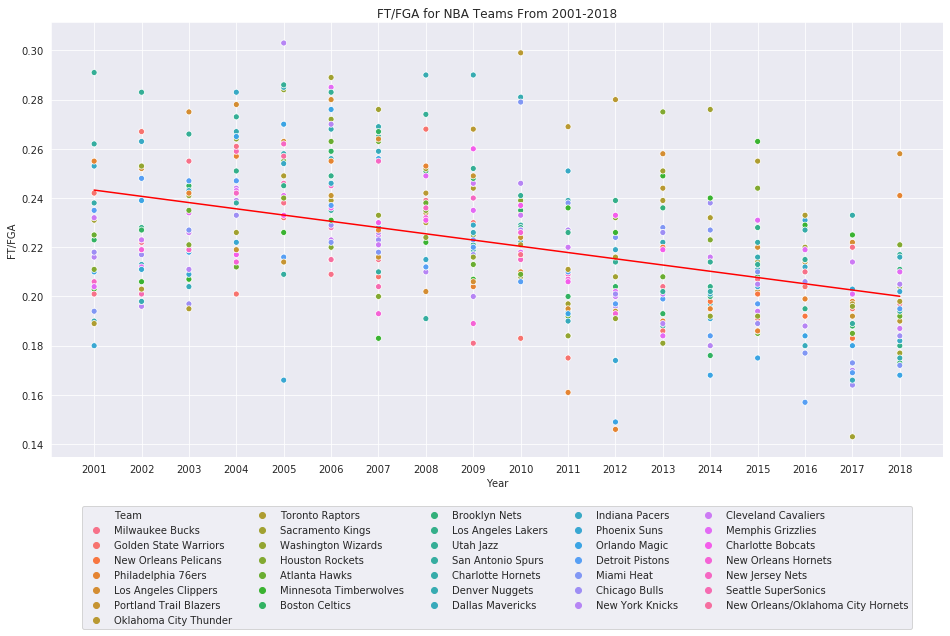

In [13]:
# Creating the regression line with np.polyfit
xaxis = team_df['Year']
yaxis = team_df['FT/FGA']      
regression_line = np.polyfit(x = xaxis, y = yaxis, deg = 1)
plt.figure(figsize=(16,8))
plt.plot(xaxis, regression_line[0] * xaxis + regression_line[1], 'r-')

# Creating the scatterplot with Seaborn
sns.scatterplot(x="Year", y="FT/FGA", hue="Team", data=team_df)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.title('FT/FGA for NBA Teams From 2001-2018')
plt.xticks(averages_df['Year'])
plt.xlabel('Year')
plt.ylabel('FT/FGA')

[This documentation](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) provides wonderful guidance on Seaborns scatter plot functionality.

There is a very interesting trend shown in the above plot! Our regression line is showing a negative slope, showing that the `FT/FGA` has been decreasing in the NBA from 2001 to 2018. If I had to guess why this was the case, it may have to do with the increasing number of 3-point shot attempts across the league. Since teams are taking more 3-point shots, they are less likely to get fouled from behind the arc and thus there are less free throws per field goal attempt.

Now let's see if we can uncover a relationship between `Win` count and a team's `FT/FGA`. We will create a new scatter plot which graphs the number of wins a team had against their `FT/FGA` for the entire 2001 to 2018 time period. We will also add a new regression line to see if there is a correlation between `Win` count and `FT/FGA`.

Text(0, 0.5, 'FT/FGA')

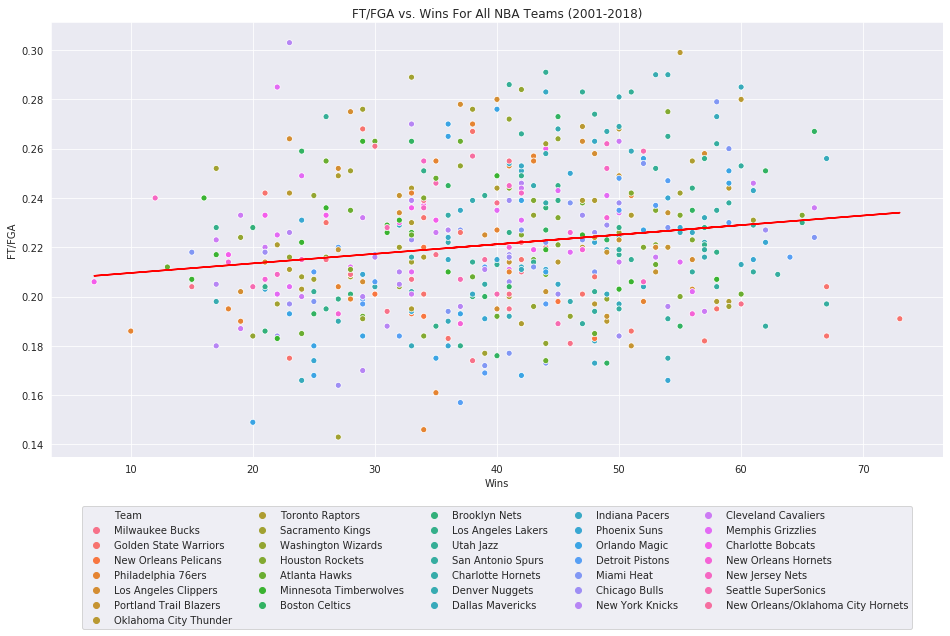

In [14]:
xaxis = team_df['W']
yaxis = team_df['FT/FGA']      
regression_line = np.polyfit(x = xaxis, y = yaxis, deg = 1)
plt.figure(figsize=(16,8))
plt.plot(xaxis, regression_line[0] * xaxis + regression_line[1], 'r-')

sns.scatterplot(x="W", y="FT/FGA", hue="Team", data=team_df)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.title('FT/FGA vs. Wins For All NBA Teams (2001-2018)')
plt.xlabel('Wins')
plt.ylabel('FT/FGA')

It looks like there is a somewhat slightly positive correlation between Wins and FT/FGA. We can check to see exactly what the correlation coefficient is with the `SciPy` library. We will calculate the [Spearman correlation coefficient](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.spearmanr.html) for this data. 

In [15]:
X = team_df['W']
y = team_df['FT/FGA']
scipy.stats.spearmanr(X, y)

SpearmanrResult(correlation=0.17491022328952407, pvalue=4.828035296220122e-05)

It looks like there was indeed a positive correlation, however it is somewhat weak as it is only about 0.175. The given pvalue is said to be testing the null-hypothesis of this data not being correlated, [according to this link.](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.spearmanr.html) We do see that this pvalue is much less than a statistical significance level of 0.05 which means we can reject this null hypothesis and we can be confident that the data is definitely somewhat correlated.

FT/FGA is a great statistic for seeing how efficient a team is with their own free throw shooting. We see that there is a weak correlation between a team's FT/FGA and their Win count, but what about their opponent's FT/FGA? Could it be possible that keeping your opponent from the free throw line is more strongly correlated to higher win counts? Let's find out! We will repeat the process above and create a new scatter plot, but this time using `Opp_FT/FGA`.

Text(0, 0.5, "Opponent's FT/FGA")

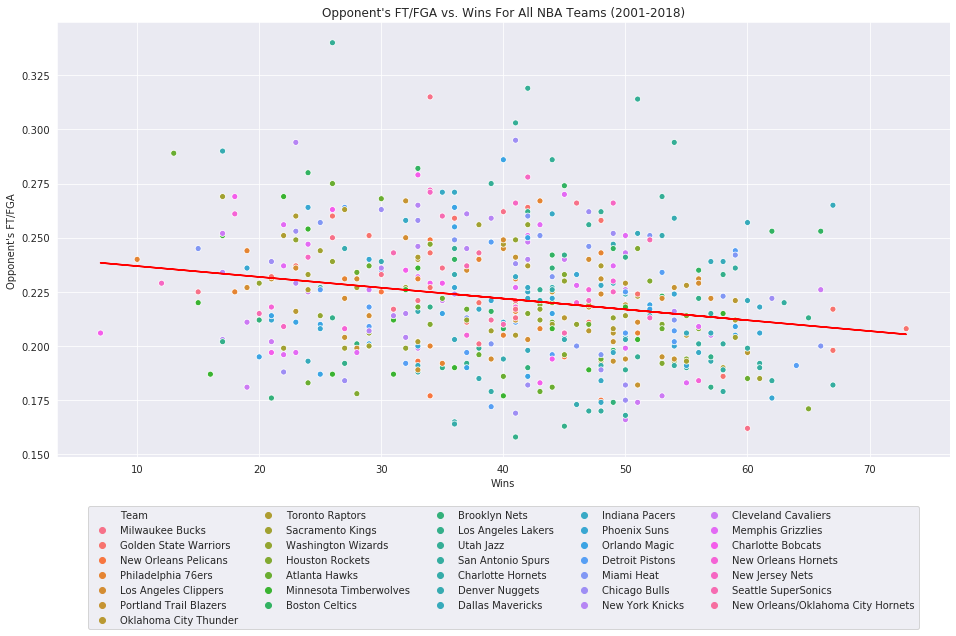

In [16]:
xaxis = team_df['W']
yaxis = team_df['Opp_FT/FGA']      
regression_line = np.polyfit(x = xaxis, y = yaxis, deg = 1)
plt.figure(figsize=(16,8))
plt.plot(xaxis, regression_line[0] * xaxis + regression_line[1], 'r-')
sns.scatterplot(x="W", y="Opp_FT/FGA", hue="Team", data=team_df)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.title("Opponent's FT/FGA vs. Wins For All NBA Teams (2001-2018)")
plt.xlabel('Wins')
plt.ylabel("Opponent's FT/FGA")

As one might expect, there is definitely a negative correlation in the above scatter plot. It makes sense that the teams with more wins would hold their opponents to smaller FT/FGA values, but now it is a matter of how strong this correlation is. Let's calculate the Spearman correlation coefficient and see.

In [17]:
X = team_df['W']
y = team_df['Opp_FT/FGA']
scipy.stats.spearmanr(X, y)

SpearmanrResult(correlation=-0.2267008211073084, pvalue=1.1867525745668437e-07)

Here we see that there is a -0.2267 correlation coefficient between Opp_FT/FGA and Win count, which is stronger than the 0.175 correlation coefficient we got before. We also got a much lower pvalue this time around, further showing the stronger correlation between Opp_FT/FGA and Win count. It looks like all the hype around defense has statistical evidence to back it up!

## IV. Analysis and Machine Learning

Although we can see subtle correlations between winning and free throw stats, we still need more proof. Another way of finding any relations between data is to incorporate Machine Learning to predict data for us. First, we need to import a Linear Regression model to use.  
  
  
This Linear Regression model uses Ordinary least squares Linear Regression. We got help using this model from https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.  
If you want to learn more about Ordinary least squares Linear Regression then take a look at https://www.statisticshowto.datasciencecentral.com/least-squares-regression-line/.

In [18]:
from sklearn.linear_model import LinearRegression

Objectively, we want to analyze how winning teams throughout NBA history have compared to losing teams based on their free throw stats. The stat we believe is most useful is the free throw factor FT/FGA. Before using the model we should add a column to the data which indicates wether or not an NBA team should be considered a winning team. By looking at the regular season records of many teams who have made the playoffs, we decided a winning team is a team which has attained at least 50 wins in the regular season.  
  
The new column will simply indicate through 'Yes' or 'No' wether or not a team is considered a "winning team".

In [58]:
winning_teams = []
for index, row in team_df.iterrows():
    if row['W'] > 50:
        winning_teams.append('Yes')
    else:
        winning_teams.append('No')
team_df['winning_team'] = winning_teams

Our first Linear Regression fit is a simple fit for the free throw factor based on year. We will use this model to predict the ideal stat for each NBA year. We established earlier that the NBA seems to be slowly declining in this area of efficient free throw shooting.

In [59]:
X = [[x] for x in team_df['Year'].values]
y = team_df['FT/FGA']
reg = LinearRegression().fit(X, y)
print("score: ", reg.score(X, y))
print("slope: ", reg.coef_[0])
print("intercept: ", reg.intercept_)

score:  0.21561286856517836
slope:  -0.0025383226012840455
intercept:  5.322418863754181


Now, we can predict the ideal free throw factor for each year using the model. Afterwards, we create a new column which holds the residual for each NBA team from 2001 - 2018. Lastly, we plot the residuals and color the data points a different color for the winning teams to make them easier to distinguish.

Text(0.5, 1.0, 'Residual of Free Throw Factor vs. Year For All NBA Teams (2001-2018)')

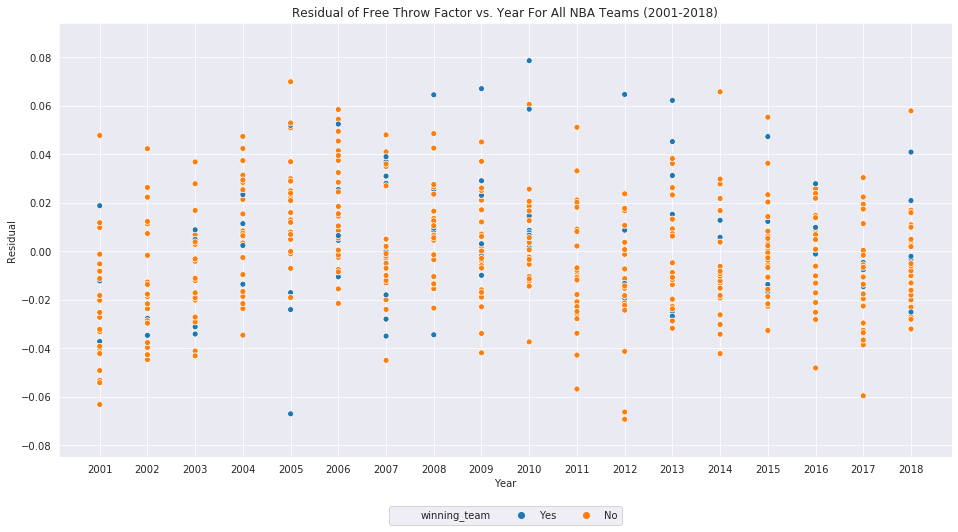

In [60]:
# use regression to predict the FT/FGA at each year
team_df['prediction'] = reg.predict(X)
# residual = observed - expected
team_df['residual'] = team_df['FT/FGA'] - team_df['prediction']
plt.figure(figsize=(16,8))
sns.scatterplot(x="Year", y="residual", hue="winning_team", data=team_df)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.xticks(averages_df['Year'])
plt.xlabel('Year')
plt.ylabel('Residual')
plt.title('Residual of Free Throw Factor vs. Year For All NBA Teams (2001-2018)')

The residual of a data point is the actual data stat minus the expected data stat. To get a better understand of residuals visit https://www.statisticshowto.datasciencecentral.com/residual/.  
We should analyze the data and look for any useful patterns. The predicted data stat was calculated by the Linear Regression model. Unfortunately, it seems both winning and losing teams span accross both negative and positive residuals. However, it seems it may be possible that winning teams are more likely to have a positive residual. We should calculate exactly what percentage of winning teams have a better free throw factor than expected.

In [62]:
count = 0
count1 = 0
for index, row in team_df.iterrows():
    if row['W'] > 50 and row['residual'] > 0:
        count += 1
    if row['W'] > 50:
        count1+=1
count/count1

0.6153846153846154

It seems we can expect about 62% of winning teams to perform above the expected FT/FGA.

Next, we should consider the another angle at analyzing free the free throw factor. After already having calculated the opposing FT/FGA, we can see if winning teams can attribute a part of their winnings to how well their opponents' free throw factor stats are. To do this we simply repeat the previous model and residual calculation but instead of the FT/FGA column we use the Opp_FT/FGA stats.

In [63]:
X = [[x] for x in team_df['Year'].values]
y = team_df['Opp_FT/FGA']
reg = LinearRegression().fit(X, y)
print("score: ", reg.score(X, y))
print("slope: ", reg.coef_[0])
print("intercept: ", reg.intercept_)

score:  0.2224852363983264
slope:  -0.0025786691414255
intercept:  5.403676538779494


Text(0.5, 1.0, 'Residual of Opposing Free Throw Factor vs. Year For All NBA Teams (2001-2018)')

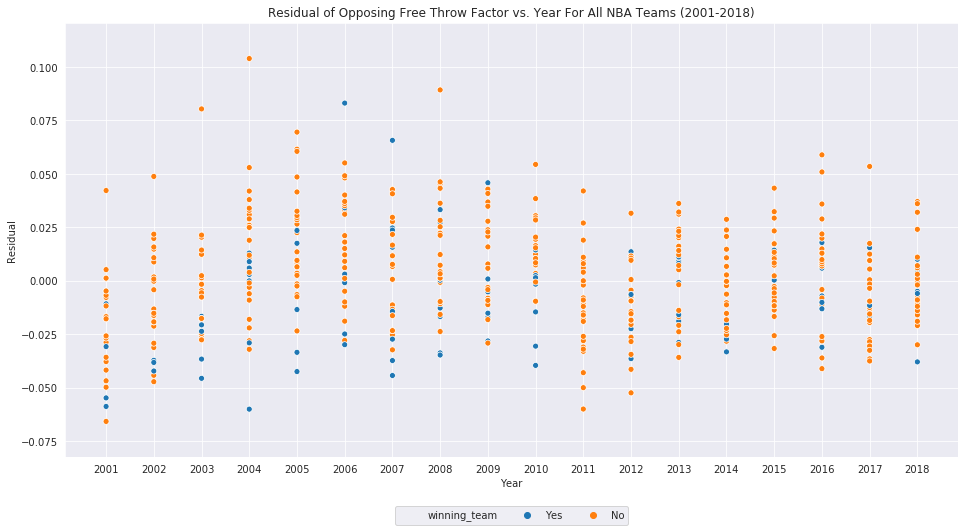

In [64]:
team_df['prediction'] = reg.predict(X)
# residual = observed - expected
team_df['residual'] = team_df['Opp_FT/FGA'] - team_df['prediction']
plt.figure(figsize=(16,8))
sns.scatterplot(x="Year", y="residual", hue="winning_team", data=team_df)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.xticks(averages_df['Year'])
plt.xlabel('Year')
plt.ylabel('Residual')
plt.title('Residual of Opposing Free Throw Factor vs. Year For All NBA Teams (2001-2018)')

This residual plot reveals a pattern. Many of the winning team data points can be observed as lower than predicted by the model. We should grab an exact percentage by counting the points under the zero residual line and dividing it by the total number of winning teams.

In [65]:
count = 0
count1 = 0
for index, row in team_df.iterrows():
    if row['W'] > 50 and row['residual'] < 0:
        count += 1
    if row['W'] > 50:
        count1+=1
count/count1

0.6495726495726496

The data shows that about 65% of winning teams restrict their opponents to less than expected free throws per field goal attempts.

Another interesting angle of analyzing the free throw factor across years is to subtract the team's free throw factor by their opposing free throw factor. This stat can determine whether having a better free throw per field goal attempt can be valuable to a winning team.  
First, we should add a new column which stores the subtraction to the dataframe. The following plot depicts each teams subtraction stat by year.

Text(0.5, 1.0, 'Residual of Opposing Free Throw Factor vs. Year For All NBA Teams (2001-2018)')

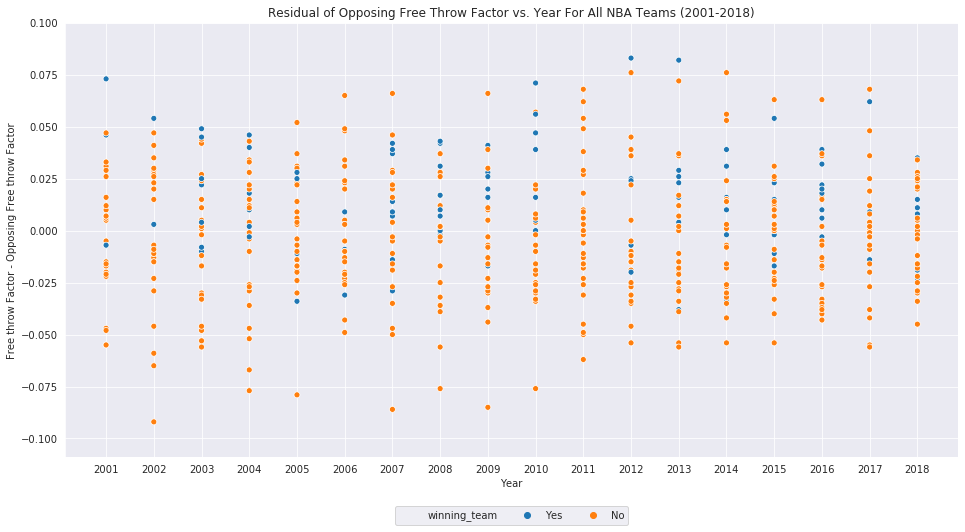

In [68]:
team_df['sub'] = team_df['FT/FGA'] - team_df['Opp_FT/FGA']
plt.figure(figsize=(16,8))
sns.scatterplot(x="Year", y="sub", hue="winning_team", data=team_df)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.xticks(averages_df['Year'])
plt.xlabel('Year')
plt.ylabel('Free throw Factor - Opposing Free throw Factor')
plt.title('Residual of Opposing Free Throw Factor vs. Year For All NBA Teams (2001-2018)')

Next, we can make another model to predict this new stat for each year using the Linear Regression Model. Then, we can calculate another residual and plot to find any patterns.

In [71]:
X = [[x] for x in team_df['Year'].values]
y = team_df['sub']
reg = LinearRegression().fit(X, y)
print("score: ", reg.score(X, y))
print("slope: ", reg.coef_[0])
print("intercept: ", reg.intercept_)

score:  4.768126398946305e-05
slope:  4.034654014145389e-05
intercept:  -0.08125767502531221


Text(0.5, 1.0, 'Residual of Opposing Free Throw Factor vs. Year For All NBA Teams (2001-2018)')

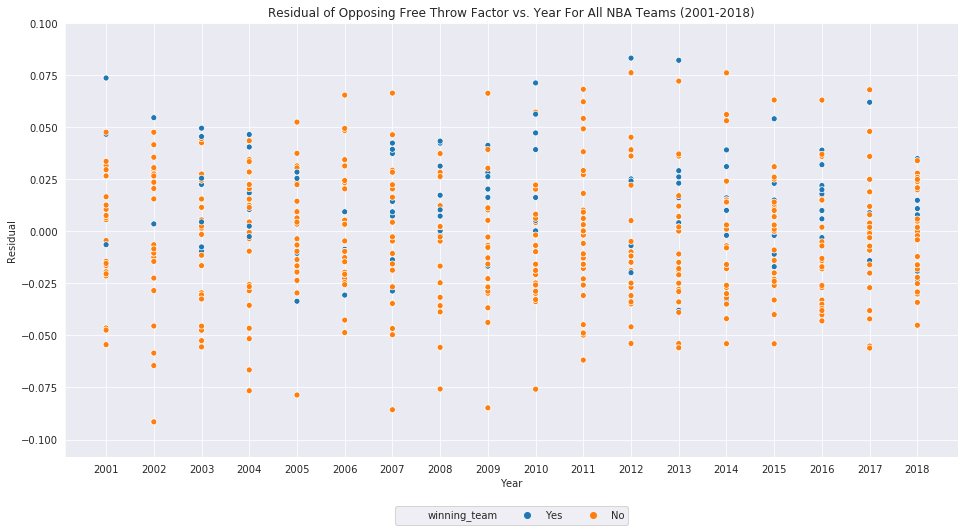

In [72]:
team_df['prediction'] = reg.predict(X)
# residual = observed - expected
team_df['residual'] = team_df['sub'] - team_df['prediction']
plt.figure(figsize=(16,8))
sns.scatterplot(x="Year", y="residual", hue="winning_team", data=team_df)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.xticks(averages_df['Year'])
plt.xlabel('Year')
plt.ylabel('Residual')
plt.title('Residual of Opposing Free Throw Factor vs. Year For All NBA Teams (2001-2018)')

This new stats provides a more telling picture of the relationship between the free throw factor and a winning team. Majority of the teams are concentrated above or very close to the predicted value. Teams who have won at least 50 games in their regular season have commonly performed better than their opponents in free throw per field goal attempt. We can calculate the exact the percentage of winning teams which share this performance.

In [75]:
count = 0
count1 = 0
for index, row in team_df.iterrows():
    if row['W'] > 50 and row['residual'] >= 0:
        count += 1
    if row['W'] > 50:
        count1+=1
print(count/count1)
count = 0
count1 = 0
for index, row in team_df.iterrows():
    if row['W'] > 50 and row['residual'] >= -.01:
        count += 1
    if row['W'] > 50:
        count1+=1
print(count/count1)

0.7094017094017094
0.8376068376068376


The percentage comes to be around 71%. Furthermore, if we include winning teams with residuals down by -.01 we can see that the percentage increases to 84%. This percentage indicates that it is rare for a winning team to fall behind in free throw per field goal attempt. Therefore, teams in the NBA with worse free throw factor comparison should work on their free throw factor to increase their chances of being a winning team.

## V. Conclusion

Through our research, data collection, visualization, and analyzation, we can safely conclude that the best professional teams in the history National Basketball Association have shown a strong positive response between free throw shooting and winning games. Although the overall efficient use of free throws has declined over the years, the best teams still continue to show their talents at getting to and making use of the free throw line. Teams who have restricted their opponents at the free throw line have also ranked higher in the league. We should encourage current teams to learn from these trends and take advantage of the free points.

In an era where the three point shot is dominating, there is still a need for professional teams in the National Basketball Association to improve upon their free throw fundamentals and efficiency. Within the past eighteen years there has been a decline in attention towards the free points offered after a foul play. However, teams with higher win percentages had ranked higher than others in making the most of their free throws. Great basketball legends like Michael Jordan and Kobe Bryant have mastered the art of free throw shooting. They encourage both current and future stars to fine tune their free throw shooting and form. Other future hall-of-famers like James Harden have also made the most of the free shots given to them. Therefore, it is highly recommended for a team competing at the highest level to not forget about the importance of free throw shooting and the impact it could have on winning a season. Never forget how valuable a free throw point could be at the end of a game. It can determine the outcome of an elimination game in mere seconds. With new rules and regulations put into effect for the safety of the players, the chances of getting to the free throw line have increased. If interested, you can read more about the value of free throw shooting here https://hoopshabit.com/2014/10/10/nba-free-throws-championship-success/. In conclusion, coaches with a winning mindset should take measures to incorporate better free throw shooting in their game plans.